### 0. Prepare expression data from TCGA

In [43]:
import pandas as pd
import glob
import os
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def addFile(file): 
	df = pd.read_csv(file, sep = "\t")
	name = os.path.basename(file)
	df['file_name'] = name
	df.columns = ['gene', 'fpkm', 'file_name']
	return(df)

def loadExpression(filepath):
	files = glob.glob(filepath)     
	dfs = (addFile(f) for f in files)
	return pd.concat(dfs, ignore_index=True)

def adjust(x): 
	return x+.0001


def topKFeatures(X, y, ifPlot = False, topK = 500):

    bestfeatures = SelectKBest(score_func=chi2, k = topK)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print("print 10 best features:\n", featureScores.nlargest(10,'Score'))
    
    if ifPlot == True:
        plt.figure()
        featureScores.nlargest(10,'Score').plot(kind='barh')
        plt.show()
    
    topk_features = featureScores.nlargest(topK,'Score').Specs.values

    return topk_features

clinical = pd.read_csv("/nfs/home/jaclyns/tcga/nationwidechildrens.org_clinical_patient_prad.txt", sep="\t")
# print(labels)

mapping = pd.read_csv("/nfs/home/jaclyns/tcga/prad.txt", sep="\t")
mapping.columns = ["case_id", "aliquot_id", "file_name"]
# print(mapping)

expression = loadExpression("/nfs/home/jaclyns/tcga/prad/*FPKM-UQ.txt")
# print(expression)

labels = clinical[['bcr_patient_uuid', 'gleason_score']].merge(mapping, right_on='case_id', left_on='bcr_patient_uuid')
labels = labels[['aliquot_id', 'gleason_score']]

expression = expression.merge(mapping, right_on='file_name', left_on='file_name')
expression = expression.dropna(subset=['aliquot_id'])
matrix = expression.pivot(index = 'aliquot_id', columns = 'gene', values = 'fpkm')
fmatrix = matrix.join(labels.set_index('aliquot_id'), on='aliquot_id')

preX = fmatrix.drop('gleason_score', 1)
prey = fmatrix[['gleason_score']]

topfs = topKFeatures(preX,prey, topK=1000)
features = preX[topfs]



print 10 best features:
                     Specs         Score
19433   ENSG00000202198.1  3.608474e+09
48631   ENSG00000262902.1  2.514031e+09
21594   ENSG00000211459.2  1.844743e+09
35533   ENSG00000237973.1  1.397182e+09
27198   ENSG00000225972.1  1.360372e+09
21558   ENSG00000210082.2  1.026426e+09
5496   ENSG00000124233.11  8.164411e+08
18000   ENSG00000198938.2  6.438067e+08
48938   ENSG00000263639.4  5.967864e+08
17968   ENSG00000198886.2  5.864804e+08


# Visualization with REFINED

In this notebook we show how to convert tabular data into images, and show those images for visualization. As it is explained in the main markdown, REFINED has two steps: Initialization with manifold learning techniques (MDS), and optimization with a search technique (hill climbing). Therefore to perform visualization with REFINED, we need to do the two steps and once we get the coordinate in the square image for each feature of the tabular data we can generate images associate with each datapoint (sample).

### 1. In the below cell we perform initialization with MDS

In [44]:
import pickle
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import scipy.misc
import Toolbox
from Toolbox import two_d_eq, Assign_features_to_pixels
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
import math
import os
os.chdir('/nfs/home/jaclyns/REFINED/data')
#%% Loading the data
# empty rows I manually removed from this file
# Feat_DF = pd.read_csv("normalized_padel_feats_NCI60_672_small.csv")
#Feat_DF = pd.read_csv("C:\\Users\\obazgir\\Desktop\\CMDS_IMAGES_NEW\\normalized_padel_feats_NCI60_672.csv")
Feat_DF = features#.head(10)

X = Feat_DF.values; #X = X[:,2:]
original_input = pd.DataFrame(data = X)                              # The MDS input should be in a dataframe format with rows as samples and columns as features
feature_names_list = original_input.columns.tolist()                 # Extracting feature_names_list (gene_names or descriptor_names)
print(">>>> Data  is loaded")

#%% MDS
nn = math.ceil(np.sqrt(len(feature_names_list))) 				     # Image dimension
Nn = original_input.shape[1] 										 # Number of features
    
transposed_input = original_input.T 							     # The MDS input data must be transposed , because we want summarize each feature by two values (as compard to regular dimensionality reduction each sample will be described by two values)
Euc_Dist = euclidean_distances(transposed_input) 					 # Euclidean distance
Euc_Dist = np.maximum(Euc_Dist, Euc_Dist.transpose())   			 # Making the Euclidean distance matrix symmetric

embedding = MDS(n_components=2)										 # Reduce the dimensionality by MDS into 2 components
mds_xy = embedding.fit_transform(transposed_input)					 # Apply MDS			

print(">>>> MDS dimensionality reduction is done")

eq_xy = two_d_eq(mds_xy,Nn)
Img = Assign_features_to_pixels(eq_xy,nn,verbose=1)					# Img is the none-overlapping coordinates generated by MDS

#%% To be saved for hill climbing
Desc = Feat_DF.columns.tolist();  #Desc = Desc[2:]					# Drug descriptors name
Dist = pd.DataFrame(data = Euc_Dist, columns = Desc, index = Desc)	# Generating a distance matrix which includes the Euclidean distance between each and every descriptor
data = (Desc, Dist, Img	)  											# Preparing the hill climbing inputs

# picklename = "Init_MDS_Euc.pickle"
picklename = "Init_PRAD_FPKM.pickle"
with open(picklename, 'wb') as f:					# The hill climbing input is a pickle, therefore everything is saved as a pickle to be loaded by the hill climbing
    pickle.dump(data, f)

>>>> Data  is loaded
>>>> MDS dimensionality reduction is done
>> Assign features to pixels: 320 / 1000
>> Assign features to pixels: 414 / 1000
>> Assign features to pixels: 473 / 1000
>> Assign features to pixels: 526 / 1000
>> Assign features to pixels: 572 / 1000
>> Assign features to pixels: 616 / 1000
>> Assign features to pixels: 655 / 1000
>> Assign features to pixels: 691 / 1000
>> Assign features to pixels: 721 / 1000
>> Assign features to pixels: 747 / 1000
>> Assign features to pixels: 775 / 1000
>> Assign features to pixels: 796 / 1000
>> Assign features to pixels: 813 / 1000
>> Assign features to pixels: 831 / 1000
>> Assign features to pixels: 849 / 1000
>> Assign features to pixels: 866 / 1000
>> Assign features to pixels: 877 / 1000
>> Assign features to pixels: 890 / 1000
>> Assign features to pixels: 902 / 1000
>> Assign features to pixels: 909 / 1000
>> Assign features to pixels: 916 / 1000
>> Assign features to pixels: 926 / 1000
>> Assign features to pixels: 933 /

### 2. Hill Climbing
Once the initializaiton is performed, then we have to apply the search optimizaition (hill climbing). The below bash script will run the search optimization.

In [22]:
mpirun -np 32 python3 /nfs/home/jaclyns/REFINED/mpiHill_UF.py --init '/nfs/home/jaclyns/REFINED/data/Init_PRAD_FPKM.pickle'   --mapping 'Mapping_REFINED.pickle'  --evolution "REFINED_Evolve.csv" --num 5


UsageError: Cell magic `%%` not found.


### 3. Visualization
Once the search optimization is performed and the coordinates for features are obtained, we can use the coordinates to generate images for visualization purpose or training CNNs. In the below code visualization is performed.

(-0.5, 25.5, 25.5, -0.5)

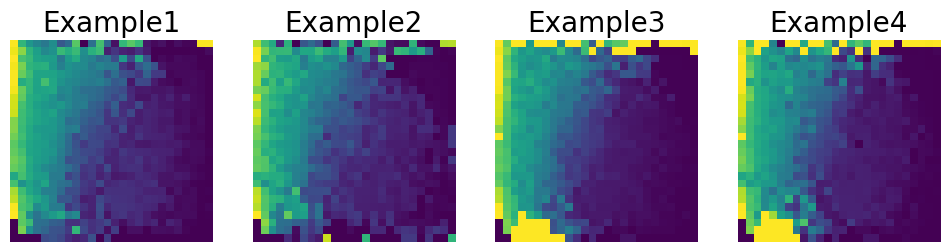

In [25]:
#%% Visualizing REFFINED images
import math
import pickle
from Toolbox import REFINED_Im_Gen
# MDS
with open('/nfs/home/jaclyns/REFINED/Mapping_REFINED.pickle','rb') as file:
    gene_names_MDS,coords_MDS,map_in_int_MDS = pickle.load(file)

# We pick the first 100 data points because of computational costs, but you can pick the entire datasets.
X_REFINED_MDS = REFINED_Im_Gen(X[:100,:],nn, map_in_int_MDS, gene_names_MDS,coords_MDS)

Font = 20

fig=plt.figure(figsize=(12,8), dpi= 100)
plt.subplot(141)
plt.imshow(X_REFINED_MDS[1,:].reshape(26,26), cmap = 'viridis')
plt.title("Example1", fontsize = Font)
plt.axis('off')

plt.subplot(142)
plt.imshow(X_REFINED_MDS[2,:].reshape(26,26), cmap = 'viridis')
plt.title("Example2", fontsize = Font)
plt.axis('off')

plt.subplot(143)
plt.imshow(X_REFINED_MDS[3,:].reshape(26,26), cmap = 'viridis')
plt.title("Example3", fontsize = Font)
plt.axis('off')


plt.subplot(144)
plt.imshow(X_REFINED_MDS[4,:].reshape(26,26), cmap = 'viridis')
plt.title("Example4", fontsize = Font)
plt.axis('off')